In [1]:
import torch 
from torch import nn
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import normalized_root_mse as nrmse_metric
from torchvision.utils import save_image
from pytorch_fid import fid_score
import os, time
from datetime import datetime

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'2.2.2'

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
# set the random seed
torch.manual_seed(316)

## Load Data

In [5]:
# Device setup
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_device()

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
)

### Download

In [6]:
# Dataset
class AlohaImageDataset(Dataset):
    def __init__(self, hf_dataset, camera_key="observation.images.top"):
        self.data = hf_dataset
        self.camera_key = camera_key
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][self.camera_key]
        image = self.transform(image)
        return image, 0

In [7]:
dataset = load_dataset("lerobot/aloha_sim_insertion_human_image")

### Split

In [8]:
full_dataset = AlohaImageDataset(dataset["train"])

len_trainset = int(len(full_dataset) * 0.8)
len_valset = len(full_dataset) - len_trainset

trainset, valset = random_split(full_dataset, [len_trainset, len_valset])

### Training Set

In [9]:
# loader for the training set
batch_size = 4
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

### Validation Set

In [10]:
# loader for the validation set
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True
)

In [11]:
image, _ = next(iter(trainloader))
print(image.shape)

torch.Size([4, 1, 480, 640])


## Build Neural Network

In [12]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


## Training and Validation

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [14]:
def add_noise(inputs, noise_factor=0.3):
    noised = inputs + torch.randn_like(inputs) * noise_factor
    noised = torch.clip(noised, 0.0, 1.0)
    return noised

### Check point

In [15]:
DATASET = "CNN"
n_epochs = 20
CKPT_DIR = f"ckpt/{DATASET}_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{n_epochs}"
os.makedirs(CKPT_DIR, exist_ok=True)
ckpt_path = os.path.join(CKPT_DIR, "autoencoder.pth")

start_epoch = 0
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting new training")

Starting new training


In [16]:
# Training
train_loss_history = []
val_loss_history = []
start_time = time.time()

for epoch in tqdm(range(start_epoch, n_epochs)):
    train_loss = 0
    model.train()
    for images, _ in trainloader:
        images = images.to(device)
        image_noised = add_noise(images)
        denoised, _ = model(image_noised)
        loss = criterion(denoised, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(trainloader)
    train_loss_history.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, _ in valloader:
            images = images.to(device)
            image_noised = add_noise(images)
            denoised, _ = model(image_noised)
            loss = criterion(denoised, images)
            val_loss += loss.item()
    val_loss /= len(valloader)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, ckpt_path)

print(f"Training complete in {time.time() - start_time:.2f} seconds.")

  5%|▌         | 1/20 [05:04<1:36:34, 304.97s/it]

Epoch 1/20 | Train Loss: 0.003 | Val Loss: 0.001


 10%|█         | 2/20 [10:00<1:29:48, 299.34s/it]

Epoch 2/20 | Train Loss: 0.001 | Val Loss: 0.001


 15%|█▌        | 3/20 [14:53<1:23:57, 296.35s/it]

Epoch 3/20 | Train Loss: 0.001 | Val Loss: 0.001


 20%|██        | 4/20 [19:44<1:18:29, 294.32s/it]

Epoch 4/20 | Train Loss: 0.001 | Val Loss: 0.001


 25%|██▌       | 5/20 [24:27<1:12:36, 290.44s/it]

Epoch 5/20 | Train Loss: 0.001 | Val Loss: 0.001


 30%|███       | 6/20 [29:11<1:07:12, 288.00s/it]

Epoch 6/20 | Train Loss: 0.001 | Val Loss: 0.001


 35%|███▌      | 7/20 [34:05<1:02:51, 290.13s/it]

Epoch 7/20 | Train Loss: 0.001 | Val Loss: 0.001


 40%|████      | 8/20 [38:59<58:17, 291.42s/it]  

Epoch 8/20 | Train Loss: 0.001 | Val Loss: 0.001


 45%|████▌     | 9/20 [43:54<53:35, 292.34s/it]

Epoch 9/20 | Train Loss: 0.001 | Val Loss: 0.001


 50%|█████     | 10/20 [48:48<48:49, 292.99s/it]

Epoch 10/20 | Train Loss: 0.001 | Val Loss: 0.001


 55%|█████▌    | 11/20 [53:32<43:32, 290.31s/it]

Epoch 11/20 | Train Loss: 0.001 | Val Loss: 0.001


 60%|██████    | 12/20 [58:13<38:19, 287.49s/it]

Epoch 12/20 | Train Loss: 0.001 | Val Loss: 0.001


 65%|██████▌   | 13/20 [1:03:22<34:17, 293.86s/it]

Epoch 13/20 | Train Loss: 0.001 | Val Loss: 0.001


 70%|███████   | 14/20 [1:08:32<29:51, 298.59s/it]

Epoch 14/20 | Train Loss: 0.001 | Val Loss: 0.001


 75%|███████▌  | 15/20 [1:13:29<24:50, 298.16s/it]

Epoch 15/20 | Train Loss: 0.001 | Val Loss: 0.001


 80%|████████  | 16/20 [1:18:24<19:49, 297.27s/it]

Epoch 16/20 | Train Loss: 0.001 | Val Loss: 0.001


 85%|████████▌ | 17/20 [1:23:17<14:48, 296.15s/it]

Epoch 17/20 | Train Loss: 0.001 | Val Loss: 0.001


 90%|█████████ | 18/20 [1:28:12<09:51, 295.70s/it]

Epoch 18/20 | Train Loss: 0.001 | Val Loss: 0.001


 95%|█████████▌| 19/20 [1:33:10<04:56, 296.24s/it]

Epoch 19/20 | Train Loss: 0.001 | Val Loss: 0.001


100%|██████████| 20/20 [1:37:59<00:00, 293.98s/it]

Epoch 20/20 | Train Loss: 0.001 | Val Loss: 0.001
Training complete in 5879.54 seconds.


## Meterics

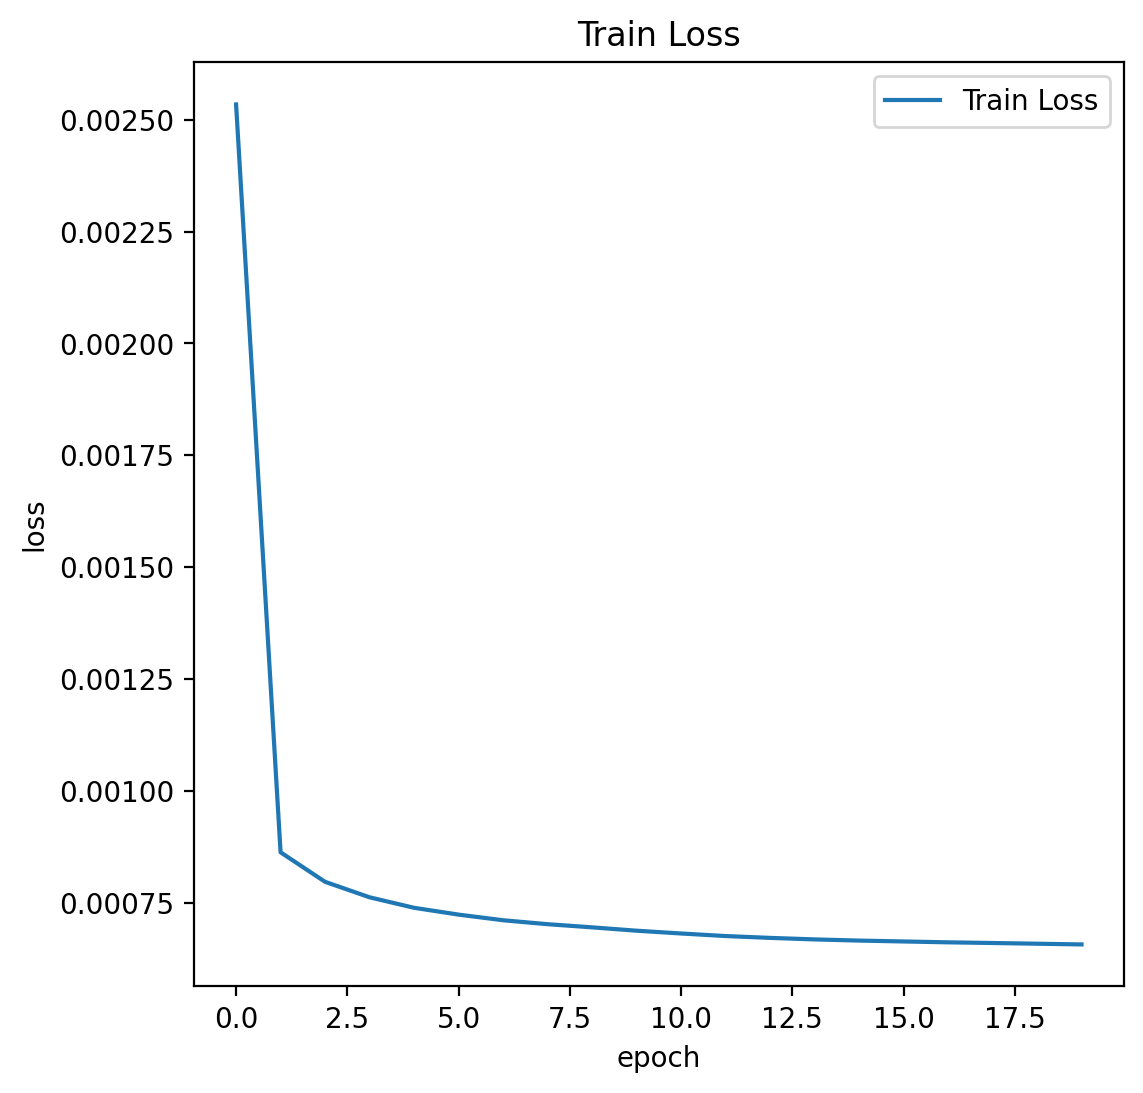

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss")
ax.legend()

plt.show()

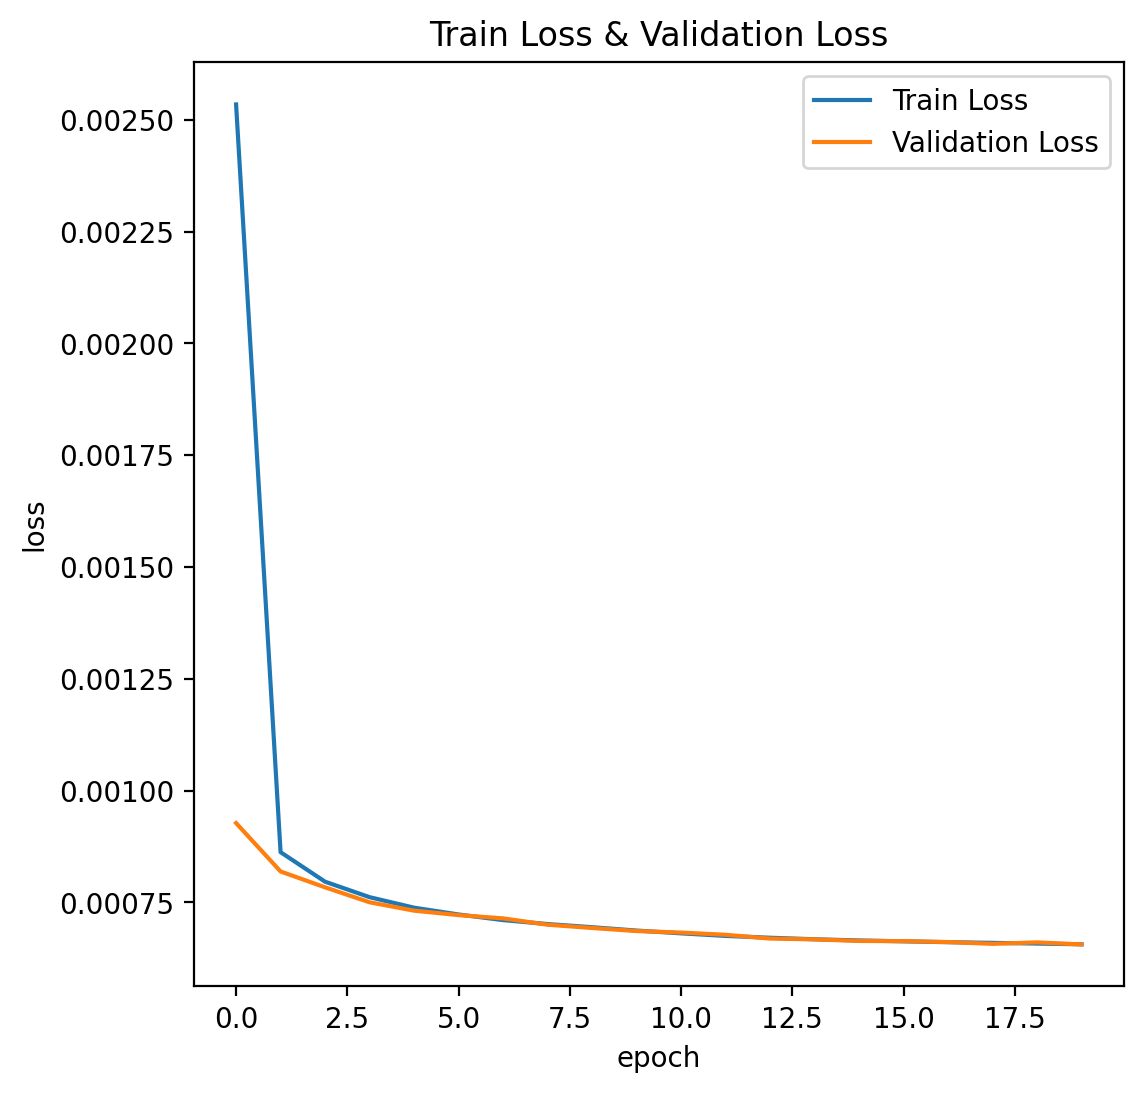

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")
ax.plot(val_loss_history, label="Validation Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss & Validation Loss")
ax.legend()

plt.show()

## Test

In [19]:
n_test_img = 6

# loader for the testset
testloader = torch.utils.data.DataLoader(
    valset,
    batch_size=n_test_img,
    shuffle=True
)

In [22]:
# model.eval()
# with torch.no_grad():
#     images, _ = next(iter(testloader))
#     images = images.to(device)
#     images_noised = add_noise(images)
#     denoised, encoded = model(images_noised)
#     latent_vis = F.interpolate(encoded, size=(480, 640), mode='bilinear', align_corners=False)

model.eval()
with torch.no_grad():
    images, _ = next(iter(testloader))  # 배치에서 일부 가져오기
    images = images.to(device)
    images_noised = add_noise(images)

    denoised, encoded = model(images_noised)

# 압축된 latent space를 480x640으로 업샘플링 (2배 압축 대비)
latent_vis = F.interpolate(encoded, size=(480, 640), mode='bilinear', align_corners=False)

# 평가 지표 계산
h, w = 240, 320
FID_REAL = "fid_temp/real_240x320"
FID_FAKE = "fid_temp/fake_240x320"
os.makedirs(FID_REAL, exist_ok=True)
os.makedirs(FID_FAKE, exist_ok=True)

psnr_list, ssim_list, nrmse_list = [], [], []

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(testloader):
        images = images.to(device)
        noised = add_noise(images)
        decoded, _ = model(noised)

        resized_original = F.interpolate(images, size=(h, w), mode='bilinear', align_corners=False)
        resized_decoded = F.interpolate(decoded, size=(h, w), mode='bilinear', align_corners=False)

        for i in range(images.size(0)):
            save_image(resized_original[i], f"{FID_REAL}/{batch_idx}_{i}.png")
            save_image(resized_decoded[i], f"{FID_FAKE}/{batch_idx}_{i}.png")

        original_np = resized_original.cpu().numpy()
        decoded_np = resized_decoded.cpu().numpy()
        for i in range(images.size(0)):
            psnr_list.append(psnr_metric(original_np[i, 0], decoded_np[i, 0], data_range=1.0))
            ssim_list.append(ssim_metric(original_np[i, 0], decoded_np[i, 0], data_range=1.0))
            nrmse_list.append(nrmse_metric(original_np[i, 0], decoded_np[i, 0]))

fid_val = fid_score.calculate_fid_given_paths([FID_REAL, FID_FAKE], batch_size=32, device=device, dims=2048)
print("=== Autoencoder Reconstruction Metrics ===")
print(f"[{h}×{w}] PSNR={np.mean(psnr_list):.3f}, NRMSE={np.mean(nrmse_list):.3f}, "
      f"SSIM={np.mean(ssim_list):.3f}, FID={fid_val:.3f}")

100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


=== Autoencoder Reconstruction Metrics ===
[240×320] PSNR=33.284, NRMSE=0.084, SSIM=0.940, FID=140.400


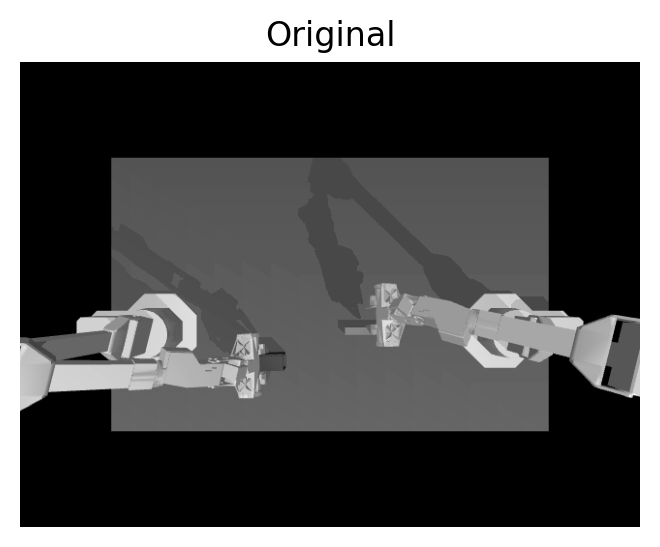

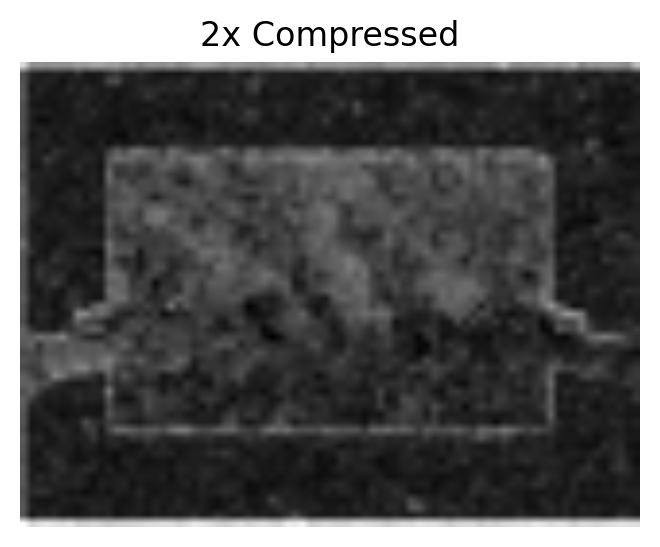

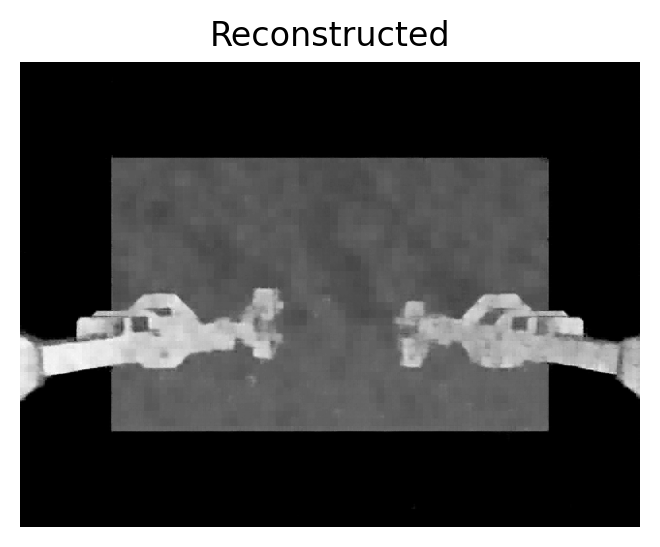

In [25]:
# # 시각화
# fig, ax = plt.subplots(nrows=3, ncols=n_test_img, figsize=(12, 6))

# for i in range(n_test_img):
#     ax[0][i].imshow(images[i].cpu().squeeze(0), cmap="gray")
#     ax[0][i].set_title("Original" if i == 0 else "")
#     ax[0][i].axis("off")

# for i in range(n_test_img):
#     ax[1][i].imshow(latent_vis[i].cpu().squeeze(0), cmap="gray")
#     ax[1][i].set_title("Encoded" if i == 0 else "")
#     ax[1][i].axis("off")

# for i in range(n_test_img):
#     ax[2][i].imshow(denoised[i].cpu().squeeze(0), cmap="gray")
#     ax[2][i].set_title("Reconstructed" if i == 0 else "")
#     ax[2][i].axis("off")

# plt.tight_layout()
# plt.show()

# 1. 원본 이미지
plt.figure(figsize=(4, 4))
plt.imshow(images[0].cpu().squeeze(0), cmap="gray")
plt.title("Original")
plt.axis("off")
plt.show()

# 2. 압축 이미지 (latent 평균)
compressed_image = latent_vis[0].cpu().mean(0)
plt.figure(figsize=(4, 4))
plt.imshow(compressed_image, cmap="gray")
plt.title("2x Compressed")
plt.axis("off")
plt.show()

# 3. 복원 이미지
plt.figure(figsize=(4, 4))
plt.imshow(denoised[0].cpu().squeeze(0), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")
plt.show()